# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\njtj\AppData\Local\conda\conda\envs\BASEMAPTEST\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
combined.corr()["sat_score"][survey_fields].plot.bar()

There is a high correlation between Number of students, Number of Teachers and number of parents and their SAT scores.  There is also a strong correlation between how safe students and teachers feel and SAT scores.  Also there is a strong correlation between student's expectations and SAT scores.

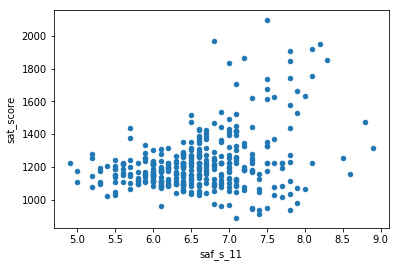

In [12]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

While not ture in every case.  In general it seems that the more safe students feel the higher their SAT scores are.  You can see schools with an average rating of 5-6 only have average scores of 1000-1400 while schools with an average rating of 7-8 have their average scores from 1000 all the way to almost 2200.

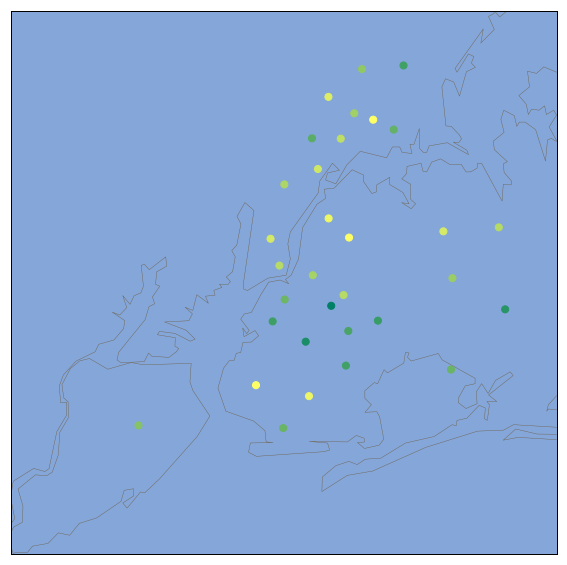

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)
plt.figure(figsize = (10,10))
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes,
          latitudes,
          s=50,
          zorder=2,
          latlon=True,
          c=districts['saf_s_11']/10,
          cmap='summer'
)
plt.show()

The safer schools are in Manhattan and northern Brooklyn(which is very gentrified) which are both very expensive areas to live.  The less safe schools are in lower Brooklyn and the Bronx which are both less expensive neighborhoods.

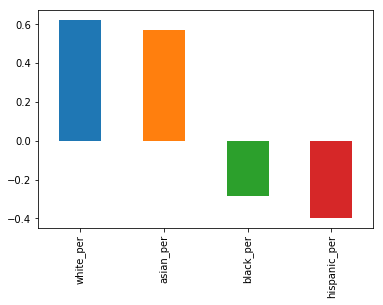

In [14]:
race_fields = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()["sat_score"][race_fields].plot.bar()

There is a very strong positive correlation between the percentage of White and Asian students and average SAT scores.  There is a very strong negative correlation between the percentage of Black and Hispanic and average SAT scores.

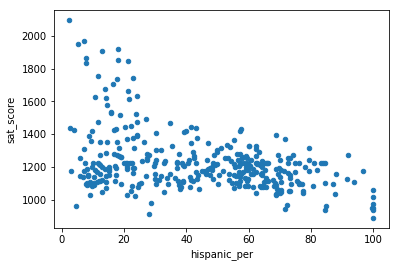

In [15]:
combined.plot.scatter('hispanic_per','sat_score')

You can clearly see that as the hispanic percent rises, SAT scores drop.  This is especially evident at the lesser percentages of hispanic students.

In [16]:
hispanic_schools = combined[combined['hispanic_per'] > 95]
print(hispanic_schools['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools all appear to be aimed at recent immigrants to the United States.

In [17]:
non_hispanic_schools = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
print(non_hispanic_schools['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


All these schools are elite specialized schools focusing in the maths and sciences.  They are also restrictive on who they allow to enroll in the school and they receive extra funding.  While this does not explain the low amount of hispanics it does explain the high testing scores.

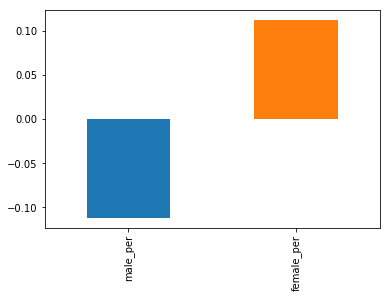

In [18]:
gender_fields = ['male_per','female_per']
combined.corr()['sat_score'][gender_fields].plot.bar()

There is a slight positive correlation between the female percentage and SAT scores as well as a slight negative correlation between the male percentage and SAT scores.

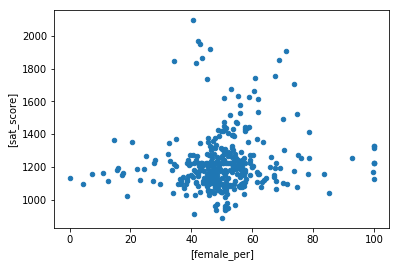

In [19]:
combined.plot.scatter(['female_per'],['sat_score'])

While the chart appears to almost be symmetrical along 50% there are a few schools between 60 and 80% female that got higher scores on their SATs which is the reason for the slight positive correlation.

In [20]:
female_schools = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(female_schools['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Again, these are all specialty schools, this time focusing more on the arts than the sciences.  They still are very selective on who they allow to attend.

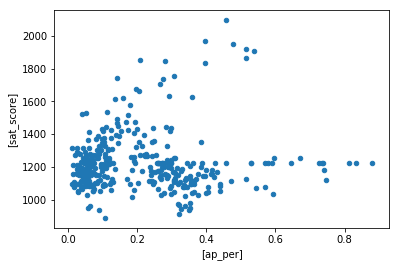

In [21]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(['ap_per'],['sat_score'])

It appears that there is a very weak correlation between the percentage of students that take an AP exam and SAT scores.

In [22]:
combined['class_size'] = combined['N_s'] / combined['N_t']
class_size = ['class_size']
print(combined.corr()['sat_score'][class_size].agg(numpy.mean))

0.35579290690703885


There appears to be a positive correlation between class size and sat score.

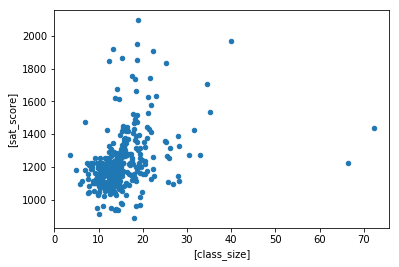

In [23]:
combined.plot.scatter(['class_size'],['sat_score'])

There definitely appears to be a slight upward trend between class size and SAT scores but it appears that almost all classes are clumped between 10-20 students and 1000-1400 SAT scores.

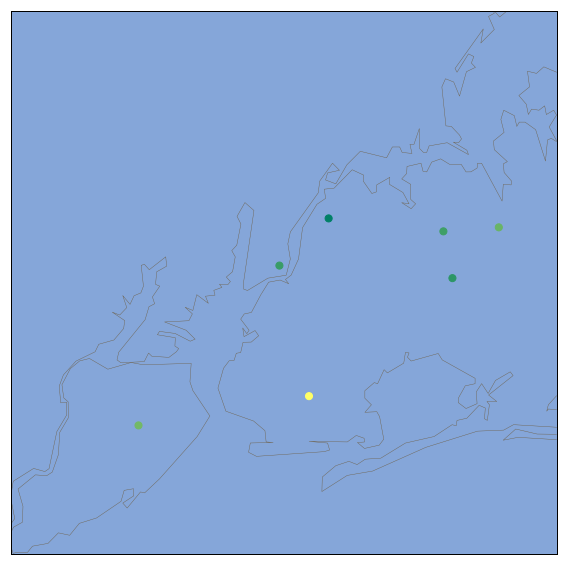

In [24]:
top_scoring_districts = districts[districts['sat_score'] > 1300]
top_lon = top_scoring_districts['lon'].tolist()
top_lat = top_scoring_districts['lat'].tolist()

n = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)
plt.figure(figsize = (10,10))
n.drawmapboundary(fill_color='#85A6D9')
n.drawcoastlines(color='#6D5F47', linewidth=.4)
n.drawrivers(color='#6D5F47', linewidth=.4)

n.scatter(top_lon,
          top_lat,
          s=50,
          zorder=2,
          latlon=True,
          c=(top_scoring_districts['sat_score']-1300)/200,
          cmap='summer'
)
plt.show()

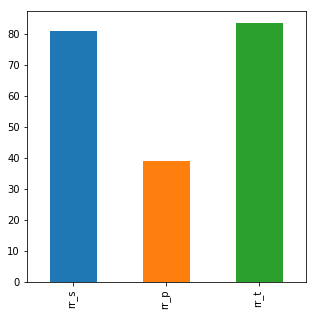

In [25]:
respondees = ['rr_s','rr_p','rr_t']
response_rates = combined[respondees].agg(numpy.mean)
plt.figure(figsize=(5,5))
response_rates.plot.bar()
plt.show()

You can see here that the response rates between students and teachers are roughly the same but parents have a much lower response rate.

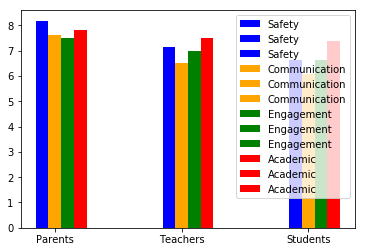

In [66]:
from numpy import arange
safety_scores_fields = ['saf_p_11','saf_t_11','saf_s_11']
communication_scores_fields = ['com_p_11','com_t_11','com_s_11']
engagement_scores_fields = ['eng_p_11','eng_t_11','eng_s_11']
academic_scores_fields = ['aca_p_11','aca_t_11','aca_s_11']

safety_scores = combined[safety_scores_fields].agg(numpy.mean)
communication_scores = combined[communication_scores_fields].agg(numpy.mean)
engagement_scores = combined[engagement_scores_fields].agg(numpy.mean)
academic_scores = combined[academic_scores_fields].agg(numpy.mean)

barwidth = .1
r1 = numpy.arange(len(safety_scores))
r2 = [x + barwidth for x in r1]
r3 = [x + barwidth for x in r2]
r4 = [x + barwidth for x in r3]

plt.bar(r1, safety_scores, color = 'b', width = barwidth, Label = 'Safety')
plt.bar(r2, communication_scores, color = 'orange', width = barwidth, Label = 'Communication')
plt.bar(r3, engagement_scores, color = 'g', width = barwidth, Label = 'Engagement')
plt.bar(r4, academic_scores, color = 'r', width = barwidth, Label = 'Academic')

plt.xticks([r + barwidth for r in range(len(safety_scores))], ['Parents','Teachers','Students'])
plt.legend()

plt.show()

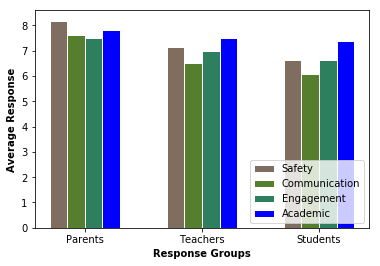

In [87]:
# set width of bar
barWidth = 0.15
 
# Set position of bar on X axis
r1 = numpy.arange(len(safety_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, safety_scores, color='#7f6d5f', width=barWidth, edgecolor='white', label='Safety')
plt.bar(r2, communication_scores, color='#557f2d', width=barWidth, edgecolor='white', label='Communication')
plt.bar(r3, engagement_scores, color='#2d7f5e', width=barWidth, edgecolor='white', label='Engagement')
plt.bar(r4, academic_scores, color='b', width=barWidth, edgecolor='white', label='Academic')
 
# Add xticks on the middle of the group bars
plt.xlabel('Response Groups', fontweight='bold')
plt.xticks([r + barWidth + .075 for r in range(len(safety_scores))], ['Parents','Teachers','Students'])
plt.ylabel('Average Response', fontweight='bold')
 
# Create legend & Show graphic
plt.legend(loc='lower right')
plt.show()


You can see here that parents consistently responded the highest, teachers responded the second highest and students responded the lowest to all the survey question.  Since the focus of school is to teach the students, not the parents or teachers, students would probably do better in school if their responses were the same as their parents.

In [94]:
combined['score'] = (combined['sat_score'] / 40) + combined['saf_s_11'] + combined['com_s_11'] + combined['eng_s_11'] + combined['aca_s_11']
top_schools = combined[combined['score'] > 75]
top_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,class_size,score
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,"525 East Houston Street\r\nNew York, NY 10002\...",40.718962,-73.976066,01,0.209123,18.700000,78.900
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,"345 Chambers Street\r\nNew York, NY 10282\r\n(...",40.717746,-74.014049,02,0.457992,18.875776,81.000
79,05M692,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",101,605.0,654.0,588.0,1847.0,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,114.000000,124.000000,...,0,0,0,"240 Convent Ave\r\nNew York, NY 10031\r\n(40.8...",40.821123,-73.948845,05,0.280788,12.310345,76.075
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,"75 West 205 Street\r\nBronx, NY 10468\r\n(40.8...",40.877056,-73.889780,10,0.394955,39.945946,76.625
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,92,636.0,648.0,636.0,1920.0,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,194.000000,302.000000,...,0,0,0,"2925 Goulden Avenue\r\nBronx, NY 10468\r\n(40....",40.871255,-73.897516,10,0.514589,13.296296,79.600
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,"149-11 Melbourne Avenue\r\nFlushing, NY 11367\...",40.734408,-73.821417,25,0.537719,22.291667,76.750
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.000000,338.000000,...,0,0,0,"94-50 159 Street\r\nJamaica, NY 11433\r\n(40.7...",40.700999,-73.798154,28,0.514354,15.346154,75.100
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.000000,905.000000,...,0,0,0,"485 Clawson Street\r\nStaten Island, NY 10306\...",40.567913,-74.115362,31,0.478261,18.574074,80.725


I made a school rating system based on the schools SAT scores and the students' responses to the survey questions.  Out of 100 possible points (60 if a school has a perfect 2400 average SAT score and then 10 for each survey response), the highest scoring school was Stuyvesant High School with 81 points.